# Find Optimal PSF
===========================

- creation 29/06/2016
- author Sylvie Dagoret-Campagne

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits

import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [2]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize

In [3]:
from scipy import stats 
from scipy import ndimage
import os
from datetime import datetime, timedelta

In [28]:
from photutils.background import Background2D

In [4]:
import libMonocamBaseImages           # my tool library written to do that CCD reduction

In [5]:
now=datetime.utcnow()  # choose UTC time
datestr=str(now)
print 'standard date format for the analysis :',datestr
#  want the following format '2016-05-10T11:55:27.267'
date_of_analysis=now.strftime('%Y-%m-%dT%H:%M:%S')
print 'fits date format for the analysis : ',date_of_analysis

standard date format for the analysis : 2016-06-29 13:34:06.401463
fits date format for the analysis :  2016-06-29T13:34:06


In [6]:
#object_name='HD158485_grat_20'
#object_name='HD159222_grat'
object_name='HD163466_none'

In [9]:
path='./HD163466_none'
rootfilename='AssScImHD163466_none_' 
NumStart=1
NumStop=10
#filename=os.path.join(path,basefilename)

In [67]:
outputtablefile='HD163466_none_TablePSF.fits'

In [12]:
filelist=libMonocamBaseImages.BuildFilelist(path,rootfilename,start=NumStart,stop=NumStop,nbchar=1)

In [13]:
filelist

['./HD163466_none/AssScImHD163466_none_1.fits',
 './HD163466_none/AssScImHD163466_none_2.fits',
 './HD163466_none/AssScImHD163466_none_3.fits',
 './HD163466_none/AssScImHD163466_none_4.fits',
 './HD163466_none/AssScImHD163466_none_5.fits',
 './HD163466_none/AssScImHD163466_none_6.fits',
 './HD163466_none/AssScImHD163466_none_7.fits',
 './HD163466_none/AssScImHD163466_none_8.fits',
 './HD163466_none/AssScImHD163466_none_9.fits',
 './HD163466_none/AssScImHD163466_none_10.fits']

In [31]:
allchannelallsciimages = []  # list of 16 lists of images series 
exposures_list = []        # sequential list of the exposures of the sky flats 
header_list = []           # list of headers
data_list = []
# get the primary block headers:
for image_file in filelist: 
    print image_file
    hdu_list = fits.open(image_file)
    header=hdu_list[0].header
    exposure=header['EXPOSURE']
    exposures_list.append(exposure)
    header_list.append(header)
    data=ccdproc.CCDData.read(image_file, hdu=0,unit='adu') 
    data_list.append(data)

./HD163466_none/AssScImHD163466_none_1.fits
./HD163466_none/AssScImHD163466_none_2.fits
./HD163466_none/AssScImHD163466_none_3.fits
./HD163466_none/AssScImHD163466_none_4.fits
./HD163466_none/AssScImHD163466_none_5.fits
./HD163466_none/AssScImHD163466_none_6.fits
./HD163466_none/AssScImHD163466_none_7.fits
./HD163466_none/AssScImHD163466_none_8.fits
./HD163466_none/AssScImHD163466_none_9.fits
./HD163466_none/AssScImHD163466_none_10.fits


## For control

uncomment for control

In [34]:
index=0

In [35]:
print exposures_list[index]

1.0


In [37]:
#header_list[index]

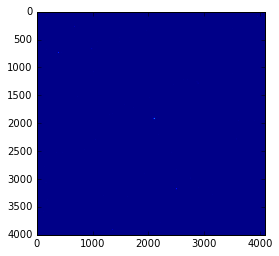

In [38]:
plt.imshow(data_list[index])

In [39]:
bkg= Background2D(data_list[index], (100, 100), filter_size=(3, 3),method='median')

In [43]:
data_list[index].data-bkg.background

array([[  2.02122243e+01,  -2.37792909e+00,  -3.01405865e+00, ...,
          4.25808038e+00,   1.99883616e+00,   2.02749997e+00],
       [ -8.15234645e+00,   6.76673887e+00,  -4.00169512e+00, ...,
          2.04851550e+00,  -1.54323358e+00,   8.30877063e-01],
       [  1.70535640e+01,  -1.16605453e+00,   1.43702591e+00, ...,
         -2.51922969e+00,   5.27430129e-01,   2.23494152e+00],
       ..., 
       [  5.27308685e+00,   1.94594021e-01,  -2.12661494e+00, ...,
          3.12457805e+00,   3.60333556e+00,   4.29079957e+00],
       [  1.39691309e+00,  -5.32999287e-01,   5.48655248e+00, ...,
          4.11973798e+00,   1.10695037e+00,   1.79170521e+01],
       [ -1.98591046e+00,   3.18446873e+00,   4.07216628e+00, ...,
         -1.28130510e+00,  -8.39388098e-01,   2.64537882e+02]])

In [45]:
correctedimage_list = []

In [46]:
for data in data_list:
    bkg= Background2D(data, (100, 100), filter_size=(3, 3),method='median')
    newimage=data-bkg.background
    correctedimage_list.append(newimage)

In [47]:
NBIMAGES=len(correctedimage_list)

In [50]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)  # Fast and numerically precise
    return (average, np.sqrt(variance))

In [71]:
image_psf=np.zeros((NBIMAGES,6))

In [52]:
DELTA_NBINSX=10
DELTA_NBINSY=10

In [72]:
# loop on images
index=-1
for image in correctedimage_list:
    index=index+1
    mean, median, std = sigma_clipped_stats(image, sigma=10.0, iters=5) 
    sources = daofind(image - median, fwhm=3.0, threshold=50.*std)
    selected_stars=sources.as_array()
    NBSTARS=selected_stars.shape[0]
    print 'image {} ==> NBSTARS = {}'.format(index,NBSTARS)
    image_psf[index,0]=index
    image_psf[index,1]=NBSTARS
    star_psfx=np.zeros(NBSTARS)
    star_psfy=np.zeros(NBSTARS)
    # loop on stars
    for istar in range(NBSTARS):
        X = int(selected_stars[istar][1])
        Y = int(selected_stars[istar][2])
        prf_image = image[Y-DELTA_NBINSY:Y+DELTA_NBINSY,X-DELTA_NBINSX:X+DELTA_NBINSX]
        oneprfX=prf_image.sum(axis=0)
        oneprfY=prf_image.sum(axis=1)
        posX,sigX=weighted_avg_and_std(np.arange(oneprfX.shape[0]),oneprfX)
        posY,sigY=weighted_avg_and_std(np.arange(oneprfY.shape[0]),oneprfY)
        star_psfx[istar]=sigX
        star_psfy[istar]=sigY
        
    all_sigx=star_psfx[np.logical_not(np.isnan(star_psfx))]
    all_sigy=star_psfy[np.logical_not(np.isnan(star_psfy))]
    all_sigx=all_sigx[all_sigx>2.4]
    all_sigy=all_sigy[all_sigy>2.4]
    print 'average prf(x) = {:2.2f} +/- {:2.2f} pixels ==> psf  {:2.2f} +/- {:2.2f} arcsec '.format(np.median(all_sigx),all_sigx.std(),np.median(all_sigx)*0.4*2.36,all_sigx.std()*0.4*2.26)
    print 'average prf(y) = {:2.2f} +/- {:2.2f} pixels ==> psf  {:2.2f} +/- {:2.2f} arcsec '.format(np.median(all_sigy),all_sigy.std(),np.median(all_sigy)*0.4*2.36,all_sigy.std()*0.4*2.26)
    image_psf[index,2]=np.median(all_sigx)
    image_psf[index,3]=np.median(all_sigy)
    image_psf[index,4]=all_sigx.std()
    image_psf[index,5]=all_sigy.std()

image 0 ==> NBSTARS = 42
average prf(x) = 3.60 +/- 0.11 pixels ==> psf  3.40 +/- 0.10 arcsec 
average prf(y) = 4.10 +/- 0.28 pixels ==> psf  3.87 +/- 0.25 arcsec 


/Users/dagoret-campagnesylvie/anaconda/envs/pyastrophys/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in sqrt


image 1 ==> NBSTARS = 43
average prf(x) = 3.61 +/- 0.14 pixels ==> psf  3.41 +/- 0.13 arcsec 
average prf(y) = 4.13 +/- 0.32 pixels ==> psf  3.90 +/- 0.29 arcsec 
image 2 ==> NBSTARS = 71
average prf(x) = 3.69 +/- 0.17 pixels ==> psf  3.48 +/- 0.15 arcsec 
average prf(y) = 4.13 +/- 0.38 pixels ==> psf  3.90 +/- 0.34 arcsec 
image 3 ==> NBSTARS = 36
average prf(x) = 3.58 +/- 0.12 pixels ==> psf  3.38 +/- 0.11 arcsec 
average prf(y) = 4.14 +/- 0.30 pixels ==> psf  3.91 +/- 0.27 arcsec 
image 4 ==> NBSTARS = 51
average prf(x) = 3.47 +/- 0.13 pixels ==> psf  3.27 +/- 0.12 arcsec 
average prf(y) = 4.12 +/- 0.34 pixels ==> psf  3.89 +/- 0.30 arcsec 
image 5 ==> NBSTARS = 46
average prf(x) = 3.70 +/- 0.15 pixels ==> psf  3.49 +/- 0.14 arcsec 
average prf(y) = 4.08 +/- 0.30 pixels ==> psf  3.86 +/- 0.27 arcsec 
image 6 ==> NBSTARS = 41
average prf(x) = 3.72 +/- 0.15 pixels ==> psf  3.51 +/- 0.14 arcsec 
average prf(y) = 4.38 +/- 0.43 pixels ==> psf  4.14 +/- 0.39 arcsec 
image 7 ==> NBSTARS = 

In [73]:
#image_psf

In [74]:
from astropy.table import Table

In [75]:
t=Table(rows=image_psf,names=('num','nbstars','prfx','pfry','sig_prfx','sig_prfy'),dtype=('i4','i4','f8','f8','f8','f8'))

In [76]:
t

num,nbstars,prfx,pfry,sig_prfx,sig_prfy
int32,int32,float64,float64,float64,float64
0,42,3.5965298218,4.1015161103,0.108020046297,0.277166519446
1,43,3.61242635444,4.13152061589,0.144973137697,0.323417226558
2,71,3.68758200509,4.13485488713,0.167005040252,0.379102235085
3,36,3.58227641138,4.13814571933,0.119342504383,0.303022903097
4,51,3.46888124803,4.11999149754,0.13302558192,0.335934851083
5,46,3.69959215711,4.08394172767,0.149843368761,0.296874027356
6,41,3.72067577442,4.38104952519,0.15129230565,0.428043616054
7,41,3.71539160053,4.03624061864,0.151812230197,0.25978629923
8,42,3.9930616935,4.365045504,0.190684599422,0.27723900551


In [80]:
t.write(outputtablefile,format='fits')